# Regressão Linear com Circuito Quântico Variacional para Aplicações em Materiais

 Neste notebook, apresentamos uma abordagem híbrida:
 
 1. **Circuito Quântico Variacional:**  
    Um circuito parametrizado implementado com Qiskit que, a partir de uma entrada (um único descritor) codificada no ângulo de rotação, gera um valor de expectativa que servirá de base para a predição.
 
 2. **Pós-Processamento Clássico:**  
    Uma transformação linear (escala e offset) é aplicada sobre a saída do circuito, resultando no valor predito para a propriedade alvo.

3. **Treinamento via Gradiente Descendente:**  
    Utilizamos o método de gradiente descendente (com gradiente aproximado por diferenças finitas) para ajustar todos os parâmetros do modelo.
 
O exemplo simula a predição de uma propriedade (por exemplo, uma propriedade física de materiais) em função de um descritor. Essa abordagem pode ser estendida para bases reais, onde os descritores podem ser obtidos a partir de cálculos computacionais ou de experimentos.


In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Importações do Amazon Braket
from braket.circuits import Circuit
from braket.aws import AwsDevice

In [25]:
# Configura o dispositivo SV1 da AWS (credenciais já configuradas)
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")


In [46]:
def quantum_circuit_model(x, theta, shots=1000):
    """
    Cria e executa um circuito quântico variacional no simulador SV1 da AWS.
    
    Parâmetros:
      - x: valor da feature (float) que é codificado via Rx.
      - theta: vetor de 2 parâmetros para os gates Ry e Rz.
      - shots: número de medições (discretização estatística).
      
    Retorna:
      - Valor esperado do operador Z calculado a partir dos resultados.
    """
    print("DEBUG: x =", x, "type(x) =", type(x))
    print("DEBUG: theta =", theta, "type(theta) =", type(theta))
    # Define o circuito
    circuit = Circuit()
    # Codifica o input x com Rx no qubit 0

    circuit.rx(0,x)
    # Aplica rotações parametrizadas Ry e Rz
    circuit.ry(0, theta[0])
    circuit.rz(0, theta[1])
    # Mede o qubit 0; o resultado será armazenado no bit 'result'
    circuit.measure(0)
    
    # Executa o circuito no dispositivo SV1 com o número definido de shots
    task = device.run(circuit, shots=shots)
    result = task.result()
    counts = result.measurement_counts
    # Calcula a expectativa do operador Z:
    # Se '0' ocorre n0 vezes e '1' ocorre n1 vezes, então <Z> = (n0 - n1) / shots
    n0 = counts.get('0', 0)
    n1 = counts.get('1', 0)
    exp_val = (n0 - n1) / shots
    print("DEBUG: expval =", exp_val, "type(exp_val) =", type(exp_val))
    return exp_val

In [47]:
def model_predict(x, params, shots=1000):
    """
    Modelo completo de predição.
    
    params: vetor de 4 parâmetros: [theta0, theta1, scale, offset]
    """
    theta = params[:2]       # Parâmetros do circuito quântico
    scale = params[2]        # Parâmetro de escala
    offset = params[3]       # Parâmetro de offset (bias)
    # Valor do circuito
    exp_val = quantum_circuit_model(x, theta, shots=shots)
    # Saída final do modelo
    return scale * exp_val + offset

In [48]:
def cost_function(params, X, y, shots=1000):
    """
    Calcula o MSE do modelo sobre o conjunto de dados.
    """
    predictions = np.array([model_predict(x, params, shots=shots) for x in X])
    return np.mean((predictions - y)**2)

def compute_gradient(params, X, y, eps=1e-4, shots=1000):
    """
    Aproxima o gradiente de cada parâmetro via diferenças finitas.
    """
    grad = np.zeros_like(params)
    for i in range(len(params)):
        params_eps = np.copy(params)
        params_eps[i] += eps
        cost_plus = cost_function(params_eps, X, y, shots=shots)
        params_eps[i] -= 2*eps
        cost_minus = cost_function(params_eps, X, y, shots=shots)
        grad[i] = (cost_plus - cost_minus) / (2 * eps)
    return grad

x		 y_true
0.0000	 4.0000
0.3173	 3.8502
0.6347	 3.4158
0.9520	 2.7402
1.2693	 1.8908
1.5867	 0.9524
1.9040	 0.0188
2.2213	 -0.8168
2.5387	 -1.4710
2.8560	 -1.8785


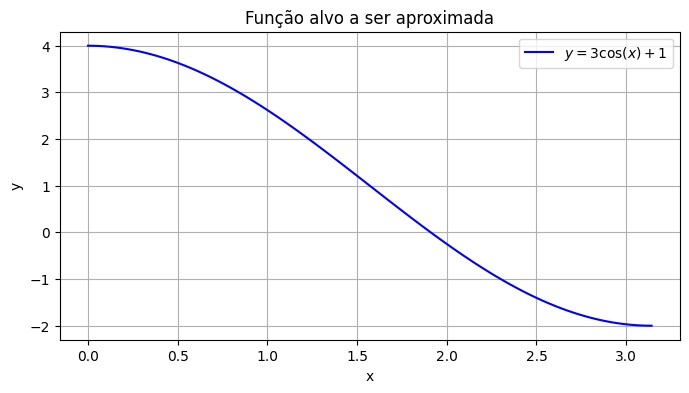

In [51]:
# %% [markdown]
# ## 3. Gerando Dados Sintéticos
# 
# Para fins ilustrativos, simulamos um conjunto de dados onde a propriedade \( y \) é uma função não linear
# de \( x \) com algum ruído, por exemplo:
# 
# \[
# y = 3 \times \cos(x) + 1 + \text{ruído}
# \]

# %% [code]
np.random.seed(42)
N = 20  # Número de amostras
X_data = np.linspace(0, np.pi, N)
true_scale = 3.0
true_offset = 1.0
# Gera os dados com ruído
y_data = true_scale * np.cos(X_data) + true_offset + np.random.normal(0, 0.1, N)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define a função alvo sem ruído
def true_function(x):
    return 3 * np.cos(x) + 1

# Gera valores de x entre 0 e pi
N = 100
x_values = np.linspace(0, np.pi, N)
y_true = true_function(x_values)

# Imprime alguns dos valores calculados
print("x\t\t y_true")
for xv, yt in zip(x_values[::10], y_true[::10]):  # imprime a cada 10 pontos para evitar muita saída
    print(f"{xv:.4f}\t {yt:.4f}")

# Plota a função
plt.figure(figsize=(8, 4))
plt.plot(x_values, y_true, label=r'$y = 3\cos(x)+1$', color='blue')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Função alvo a ser aproximada")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# %% [markdown]
# ## 4. Treinamento do Modelo via Gradiente Descendente
# 
# Inicializamos os parâmetros do modelo (os dois para o circuito e o scale/offset) com valores aleatórios.
# Em seguida, atualizamos os parâmetros iterativamente utilizando o gradiente aproximado.
# 
# **Nota:** Como cada avaliação do circuito envolve a comunicação com o simulador SV1 da AWS, o treinamento pode levar algum tempo.

# %% [code]
# Parâmetros iniciais: [theta0, theta1, scale, offset]
params = np.random.randn(4)

learning_rate = 0.1
num_iters = 200
shots = 1000  # número de shots para cada execução do circuito

cost_history = []
for i in range(num_iters):
    current_cost = cost_function(params, X_data, y_data, shots=shots)
    cost_history.append(current_cost)
    grad = compute_gradient(params, X_data, y_data, eps=1e-4, shots=shots)
    params -= learning_rate * grad
    if i % 10 == 0:
        print(f"Iteração {i}, Custo: {current_cost:.4f}")

print("\nParâmetros treinados:", params)

In [ ]:

# %% [markdown]
# ## 5. Visualização dos Resultados
# 
# Plotamos a evolução do custo ao longo das iterações e comparamos as predições do modelo com os dados reais.

# %% [code]
plt.figure(figsize=(8, 4))
plt.plot(cost_history, 'b-')
plt.xlabel("Iteração")
plt.ylabel("Custo (MSE)")
plt.title("Convergência do Gradiente Descendente")
plt.show()

# Gera predições para visualização em um intervalo de x
X_plot = np.linspace(0, np.pi, 100)
y_pred = np.array([model_predict(x, params, shots=shots) for x in X_plot])

plt.figure(figsize=(8, 4))
plt.scatter(X_data, y_data, label="Dados Sintéticos")
plt.plot(X_plot, y_pred, color='red', label="Modelo Híbrido")
plt.xlabel("x (descritor)")
plt.ylabel("y (propriedade alvo)")
plt.title("Predições do Modelo com SV1 (AWS)")
plt.legend()
plt.show()